In [1]:
import requests
from bs4 import BeautifulSoup, SoupStrainer
import re
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import seaborn as sns

In [2]:
base_url = 'https://english.mubasher.info/markets/EGX/stocks/'

### Getting Companies Listed in EGX from Trading View:

In [3]:
# resp = requests.get('https://www.tradingview.com/symbols/EGX-EGX30/components/')
resp = requests.get('https://www.tradingview.com/markets/stocks-egypt/market-movers-large-cap/')
soup = BeautifulSoup(resp.text)
symbols = []
for i, tag in enumerate(soup.findAll('a', attrs={'class': re.compile('^apply-common-tooltip')})):
    if(i%2==0):
        symbols.append(tag.string)
symbols

['COMI',
 'ABUK',
 'ETEL',
 'EAST',
 'QNBA',
 'MFPC',
 'SWDY',
 'EFIH',
 'ALCN',
 'GPPL',
 'EKHO',
 'ORAS',
 'ESRS',
 'HRHO',
 'FWRY',
 'TMGH',
 'FAIT',
 'IRAX',
 'EGAL',
 'SKPC',
 'EMFD',
 'HELI',
 'CIEB',
 'AMOC',
 'JUFO',
 'EFID',
 'HDBK',
 'ADIB',
 'ORHD',
 'ORWE',
 'EGCH',
 'CLHO',
 'MNHD',
 'EGBE',
 'EGSA',
 'IRON',
 'EXPA',
 'CIRA',
 'AUTO',
 'SAUD',
 'PHDC',
 'SCTS',
 'CSAG',
 'RAYA',
 'CICH',
 'OCDI',
 'MTIE',
 'CNFN',
 'SPHT',
 'OLFI',
 'EFIC',
 'SUGR',
 'BINV',
 'CANA',
 'PHAR',
 'EGAS',
 'ZMID',
 'BIOC',
 'ARCC',
 'CCAP',
 'EGTS',
 'MIPH',
 'MBSC',
 'TALM',
 'RMDA',
 'ATQA',
 'MPRC',
 'MHOT',
 'PRDC',
 'POUL',
 'MCRO',
 'ELEC',
 'MICH',
 'SAIB',
 'ISPH',
 'DOMT',
 'ACRO',
 'IDRE',
 'BTFH',
 'MCQE',
 'NAHO',
 'DEIN',
 'MOIN',
 'ELSH',
 'MOIL',
 'ISMQ',
 'MFSC',
 'NINH',
 'OCPH',
 'UNIT',
 'OIH',
 'GSSC',
 'AMES',
 'AIVC',
 'WCDF',
 'PHTV',
 'PACH',
 'ACGC',
 'ELKA',
 'UEFM']

In [4]:
div_tags = SoupStrainer(attrs={'class': re.compile('^stock-overview')})

In [5]:
soup = BeautifulSoup(resp.text, 'lxml', parse_only=div_tags)
print(soup.prettify())

<!DOCTYPE html>



### Defining Filtering Criteria

In [6]:
def has_book_value(tag):
    return tag.string and re.compile("^Book Value").search(tag.string.get_text())

def has_market_cap(tag):
    return tag.string and re.compile("Market Cap").search(tag.string.get_text())

def has_total_shares(tag):
    return tag.string and re.compile("Current Total Shares").search(tag.string.get_text())
def has_eps(tag):
    return tag.string and re.compile("EPS").search(tag.string.get_text())

#### Defining DataFrame Columns List

In [7]:
symbols_list = []
update_dates = []
ratios = []
names = []
EPS = []
prices = []
book_values =[]

### Scraping The Page OF Each Company

In [8]:
for symbol in symbols:
    resp = requests.get(base_url+symbol)
    div_tags = SoupStrainer(attrs={'class': re.compile('^stock-overview')})
    soup = BeautifulSoup(resp.text, 'lxml', parse_only=div_tags)
    
    book_value_span = soup.find_all(has_book_value)[0]
    eps_span = soup.find_all(has_eps)[0]
    quarter = book_value_span.find_next_sibling('span').find('span', class_='market-summary__date').string.get_text()
    
    book_value = float(book_value_span.find_next_sibling('span').find('span', class_=re.compile('^number')).string.replace(',',''))
    
    currency = book_value_span.find_next_sibling('span').find('span', string='Egyptian Pound')

                                                              
    eps = float(eps_span.find_next_sibling('span').find('span', class_=re.compile('^number')).string.get_text())
    
    h1_tags = SoupStrainer('h1')
    soup = BeautifulSoup(resp.text, 'lxml', parse_only=h1_tags)
    name = soup.find('h1').string
 

    
    price_tags = SoupStrainer('div', attrs={'class': re.compile('^market-summary__last-price')})
    soup = BeautifulSoup(resp.text, 'lxml', parse_only=price_tags)
    last_price = float(soup.find().string)
    if book_value != 0 and currency != None:
        p2B = round(last_price/book_value,2)
        if p2B < 1 and p2B > 0:
            symbols_list.append(symbol)
            update_dates.append(quarter.replace('\n', ' ').strip("Based on: "))
            ratios.append(p2B)
            names.append(name)
            EPS.append(eps)
            prices.append(last_price)
            book_values.append(book_value)
    

### Loading The Data to Pandas Data Frame:

In [18]:
data = {'Company': names, 'Symbol': symbols_list,'EPS': EPS, 'Price':prices,'Book Value': book_values, 'P/B': ratios, 'Date of Book Value Update': update_dates}

df = pd.DataFrame(data)
df['year'] = df['Date of Book Value Update'].str[-4:]
df['Quarter'] = df['Date of Book Value Update'].str.split().str[0]
df['Company'] = df['Company'].str.split().str[:-1].str.join(' ')
quarter_order = ['First', 'Second', 'Third', 'Fourth']
df['Quarter'] = pd.Categorical(df['Quarter'], categories=quarter_order, ordered=True)
df = df.sort_values(by=['year','Quarter'], ascending=False)
df = df[['Company', 'Symbol', 'P/B','Price','Book Value','Date of Book Value Update']]
df = df.reset_index(drop=True)
df



,Company,Symbol,P/B,Price,Book Value,Date of Book Value Update
0,Arab Cotton Ginning,ACGC,0.66,3.42,5.18,First Quarter 2023
1,Telecom Egypt,ETEL,0.89,24.00,27.09,Fourth Quarter 2022
2,Qatar National Bank Al Ahli,QNBA,0.70,17.57,25.11,Fourth Quarter 2022
3,Talaat Moustafa Group Holding,TMGH,0.51,8.92,17.39,Fourth Quarter 2022
4,Emaar Misr for Development SAE,EMFD,0.46,2.96,6.38,Fourth Quarter 2022
5,Oriental Weavers Carpet,ORWE,0.91,13.73,15.17,Fourth Quarter 2022
6,Ghabbour Auto SAE,AUTO,0.35,5.34,15.41,Fourth Quarter 2022
7,Al Baraka Bank - Egypt,SAUD,0.77,8.00,10.44,Fourth Quarter 2022
8,Palm Hills Development Co SAE,PHDC,0.61,1.93,3.19,Fourth Quarter 2022
9,Six of October Development and Investment,OCDI,0.69,13.94,20.35,Fourth Quarter 2022


### Plotting Book Value Vs Price

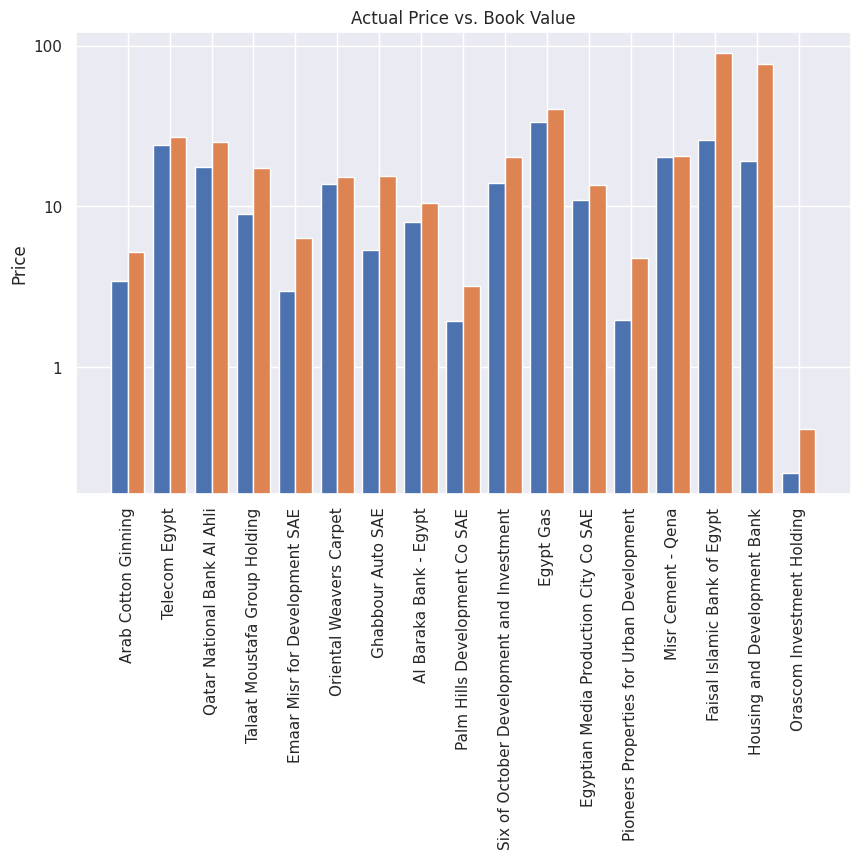

In [19]:
fig, ax = plt.subplots(figsize=(10,6))

x = np.arange(len(df))
ax.set_xticks(x)
ax.set_xticklabels(df['Company'], rotation='vertical')

ax.bar(x-0.2, df['Price'], width=0.4, label='Actual Price')
ax.bar(x+0.2, df['Book Value'], width=0.4, label='Book Value')

ax.set_ylabel('Price')

ax.set_title('Actual Price vs. Book Value')


plt.yscale('log')

formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)

plt.show()
